In [30]:
!poetry add scikit-learn xgboost

Using version ^1.5.1 for scikit-learn
Using version ^2.1.1 for xgboost

Updating dependencies
Resolving dependencies... (0.7s)

Package operations: 6 installs, 0 updates, 0 removals

  - Installing joblib (1.4.2): Pending...
  - Installing nvidia-nccl-cu12 (2.22.3): Pending...
  - Installing scipy (1.14.0): Pending...
  - Installing threadpoolctl (3.5.0): Pending...
  - Installing threadpoolctl (3.5.0): Downloading... 0%
  - Installing threadpoolctl (3.5.0): Downloading... 100%
  - Installing threadpoolctl (3.5.0): Installing...
  - Installing threadpoolctl (3.5.0)
  - Installing scipy (1.14.0): Pending...
  - Installing threadpoolctl (3.5.0)
  - Installing nvidia-nccl-cu12 (2.22.3): Downloading... 0%
  - Installing scipy (1.14.0): Pending...
  - Installing threadpoolctl (3.5.0)
  - Installing threadpoolctl (3.5.0)
  - Installing scipy (1.14.0): Downloading... 0%
  - Installing threadpoolctl (3.5.0)
  - Installing nvidia-nccl-cu12 (2.22.3): Downloading... 0%
  - Installing scipy (1.14.

In [7]:
from geopy.geocoders import Nominatim
from geopy.adapters import AdapterHTTPError
import requests
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def get_lat_long_for_cityname(city: str):
    """Converts a string of a city name provided into
    lat/long coordinates."""

    geolocator = Nominatim(user_agent="MyApp")

    try:
        location = geolocator.geocode(city)
        lat = location.latitude
        long = location.longitude

        # log the coordinates retrieved
        logger.info(f"Coordinates for {city}: {lat}/{long}")

    # if the coordinates cannot be retrieved log a warning
    except (AttributeError, KeyError, ValueError, AdapterHTTPError) as err:
        logger.warning(
            f"""Coordinates for {city}: could not be retrieved.
            Error: {err}"""
        )
        lat = "NA"
        long = "NA"

    city_coordinates = {"city": city, "lat": lat, "long": long}

    return city_coordinates


def get_zipcode_for_lat_long(lat: float, long: float):
    """Converts lat/long coordinates into a zipcode."""

    geolocator = Nominatim(user_agent="MyApp")

    try:
        location = geolocator.reverse((lat, long), exactly_one=True)
        zipcode = location.raw['address']['postcode']

        # log the zipcode retrieved
        logger.info(f"Zipcode for {lat}/{long}: {zipcode}")

    # if the zipcode cannot be retrieved log a warning
    except (AttributeError, KeyError, ValueError, AdapterHTTPError) as err:
        logger.warning(
            f"""Zipcode for {lat}/{long}: could not be retrieved.
            Error: {err}"""
        )
        zipcode = "NA"

    return {"lat": lat, "long": long, "zipcode": zipcode}


def get_current_weather_from_city_coordinates(coordinates, timestamp):
    """Queries an open weather API for the current weather at the
    coordinates provided."""

    lat = coordinates["lat"]
    long = coordinates["long"]
    city = coordinates["city"]

    r = requests.get(
        f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={long}&current_weather=true"
    )

    # if the API call is successful log the current temp
    if r.status_code == 200:
        current_weather = r.json()["current_weather"]

        logger.info(
            "The current temperature in {0} is {1}°C".format(
                city, current_weather["temperature"]
            )
        )

    # if the API call is not successful, log a warning
    else:
        current_weather = {
            "temperature": "NULL",
            "windspeed": "NULL",
            "winddirection": "NULL",
            "weathercode": "NULL",
            "time": f"{timestamp}",
        }

        logger.warning(
            f"""
                Could not retrieve current temperature for {city} at
                {lat}/{long} from https://api.open-meteo.com.
                Request returned {r.status_code}.
            """
        )

    return {
        "city": city,
        "lat": lat,
        "long": long,
        "current_weather": current_weather,
        "API_response": r.status_code,
    }



In [16]:
import requests
import logging

logger = logging.getLogger(__name__)

def get_past_weather_for_city(city: str, date: str):
    """Queries the Open-Meteo API for the past weather at the
    city and date provided."""

    coordinates = get_lat_long_for_cityname(city)
    lat = coordinates["lat"]
    long = coordinates["long"]

    r = requests.get(
        f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={long}&start_date={date}&end_date={date}&daily=temperature_2m_max,temperature_2m_min,windspeed_10m_max,winddirection_10m_dominant&timezone=GMT"
    )

    # Print the entire response for debugging
    response_json = r.json()
    logger.info(f"API Response: {response_json}")

    # if the API call is successful log the past weather
    if r.status_code == 200 and "daily" in response_json:
        past_weather = response_json["daily"]

        logger.info(
            "The past weather in {0} on {1} was {2}".format(
                city, date, past_weather
            )
        )

    # if the API call is not successful, log a warning
    else:
        past_weather = {
            "temperature_2m_max": ["NULL"],
            "temperature_2m_min": ["NULL"],
            "windspeed_10m_max": ["NULL"],
            "winddirection_10m_dominant": ["NULL"],
            "time": [f"{date}"],
        }

        logger.warning(
            f"""
                Could not retrieve past weather for {city} on
                {date} from https://archive-api.open-meteo.com.
                Request returned {r.status_code}.
            """
        )

    return {
        "city": city,
        "lat": lat,
        "long": long,
        "past_weather": past_weather,
        "API_response": r.status_code,
    }

# Assuming get_lat_long_for_cityname function is defined elsewhere

city = "Paris"
date = "2023-06-01"  # Note: Use past date, as future dates won't work

# Get past weather for a city and date
past_weather = get_past_weather_for_city(city, date)
print(past_weather)

INFO:__main__:Coordinates for Paris: 48.8588897/2.3200410217200766
INFO:__main__:API Response: {'latitude': 48.89279, 'longitude': 2.2920206, 'generationtime_ms': 0.11801719665527344, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 38.0, 'daily_units': {'time': 'iso8601', 'temperature_2m_max': '°C', 'temperature_2m_min': '°C', 'windspeed_10m_max': 'km/h', 'winddirection_10m_dominant': '°'}, 'daily': {'time': ['2023-06-01'], 'temperature_2m_max': [26.1], 'temperature_2m_min': [13.7], 'windspeed_10m_max': [21.6], 'winddirection_10m_dominant': [31]}}
INFO:__main__:The past weather in Paris on 2023-06-01 was {'time': ['2023-06-01'], 'temperature_2m_max': [26.1], 'temperature_2m_min': [13.7], 'windspeed_10m_max': [21.6], 'winddirection_10m_dominant': [31]}


{'city': 'Paris', 'lat': 48.8588897, 'long': 2.3200410217200766, 'past_weather': {'time': ['2023-06-01'], 'temperature_2m_max': [26.1], 'temperature_2m_min': [13.7], 'windspeed_10m_max': [21.6], 'winddirection_10m_dominant': [31]}, 'API_response': 200}


In [26]:
import requests
import logging
from datetime import datetime, timedelta
import pandas as pd

logger = logging.getLogger(__name__)

def get_weather_for_timestamp(city: str, timestamp: datetime):
    """Queries the Open-Meteo API for weather data at a specific timestamp for the given city."""
    coordinates = get_lat_long_for_cityname(city)
    lat = coordinates["lat"]
    long = coordinates["long"]

    date = timestamp.strftime('%Y-%m-%d')
    hour = timestamp.hour

    r = requests.get(
        f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={long}&start_date={date}&end_date={date}&hourly=temperature_2m,rain&timezone=GMT"
    )

    response_json = r.json()
    logger.info(f"API Response: {response_json}")

    if r.status_code == 200 and "hourly" in response_json:
        hourly_data = response_json["hourly"]
        weather = {
            "temperature": hourly_data["temperature_2m"][hour],
            "rain": hourly_data["rain"][hour]
        }
        logger.info(f"Retrieved weather data for {city} at {timestamp}")
    else:
        weather = {
            "temperature": None,
            "rain": None
        }
        logger.warning(
            f"Could not retrieve weather for {city} at {timestamp}. "
            f"Request returned {r.status_code}."
        )

    return weather

def get_weather_for_timerange(city: str, start_timestamp: datetime, end_timestamp: datetime):
    """Queries the Open-Meteo API for hourly weather data for the given city and date range."""
    coordinates = get_lat_long_for_cityname(city)
    lat = coordinates["lat"]
    long = coordinates["long"]

    start_date = start_timestamp.strftime('%Y-%m-%d')
    end_date = end_timestamp.strftime('%Y-%m-%d')

    r = requests.get(
        f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={long}&start_date={start_date}&end_date={end_date}&hourly=temperature_2m,rain&timezone=GMT"
    )

    response_json = r.json()
    logger.info(f"API Response: {response_json}")

    if r.status_code == 200 and "hourly" in response_json:
        hourly_weather = response_json["hourly"]
        logger.info(f"Retrieved hourly weather data for {city} from {start_date} to {end_date}")
    else:
        hourly_weather = {
            "time": [],
            "temperature_2m": [],
            "rain": []
        }
        logger.warning(
            f"Could not retrieve hourly weather for {city} from {start_date} to {end_date}. "
            f"Request returned {r.status_code}."
        )

    return hourly_weather

# Assuming get_lat_long_for_cityname function is defined elsewhere

def process_bike_data_with_weather(parquet_file: str, city: str):
    # Read the bike data
    df = pd.read_parquet(parquet_file)
    
    # Convert timestamp to datetime if it's not already, remove timezone info, and set precision to nanoseconds
    df['record_timestamp'] = pd.to_datetime(df['record_timestamp'], utc=True).dt.tz_localize(None).astype('datetime64[ns]')
    
    # Sort the dataframe by timestamp
    df = df.sort_values('record_timestamp')
    
    # Get the start and end timestamps
    start_timestamp = df['record_timestamp'].min()
    end_timestamp = df['record_timestamp'].max()
    
    # Get hourly weather data for the entire date range
    weather_data = get_weather_for_timerange(city, start_timestamp, end_timestamp)
    
    # Convert weather data to a DataFrame
    weather_df = pd.DataFrame(weather_data)
    weather_df['time'] = pd.to_datetime(weather_df['time'], utc=True).dt.tz_localize(None).astype('datetime64[ns]')
    
    # Merge bike data with weather data
    result = pd.merge_asof(df, weather_df, left_on='record_timestamp', right_on='time', 
                           direction='nearest', tolerance=pd.Timedelta('30min'))
    
    # Drop the 'time' column as it's redundant with 'record_timestamp'
    result = result.drop(columns=['time'])
    
    return result

# Usage
city = "Paris"
parquet_file = 'numbikesavailable.parquet'
result_df = process_bike_data_with_weather(parquet_file, city)

# Display the first few rows and info of the result
print(result_df.head(60))
print(result_df.info())

INFO:__main__:Coordinates for Paris: 48.8588897/2.3200410217200766
INFO:__main__:API Response: {'latitude': 48.89279, 'longitude': 2.2920206, 'generationtime_ms': 0.1430511474609375, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 38.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C', 'rain': 'mm'}, 'hourly': {'time': ['2024-06-02T00:00', '2024-06-02T01:00', '2024-06-02T02:00', '2024-06-02T03:00', '2024-06-02T04:00', '2024-06-02T05:00', '2024-06-02T06:00', '2024-06-02T07:00', '2024-06-02T08:00', '2024-06-02T09:00', '2024-06-02T10:00', '2024-06-02T11:00', '2024-06-02T12:00', '2024-06-02T13:00', '2024-06-02T14:00', '2024-06-02T15:00', '2024-06-02T16:00', '2024-06-02T17:00', '2024-06-02T18:00', '2024-06-02T19:00', '2024-06-02T20:00', '2024-06-02T21:00', '2024-06-02T22:00', '2024-06-02T23:00', '2024-06-03T00:00', '2024-06-03T01:00', '2024-06-03T02:00', '2024-06-03T03:00', '2024-06-03T04:00', '2024-06-03T05:00', '2024-06-03T06:00', '2024-0

          record_timestamp  total_bikes  temperature_2m  rain
0  2024-06-02 18:37:00.476      33640.0            15.4   0.0
1  2024-06-02 18:39:00.474      16829.0            15.4   0.0
2  2024-06-02 18:42:00.865      16867.0            15.4   0.0
3  2024-06-02 18:43:00.490      16839.0            15.4   0.0
4  2024-06-02 18:45:00.432      16842.0            15.4   0.0
5  2024-06-02 18:47:00.302      16899.0            15.4   0.0
6  2024-06-02 18:49:00.340      16904.0            15.4   0.0
7  2024-06-02 18:51:00.486      16918.0            15.4   0.0
8  2024-06-02 18:53:00.320      16954.0            15.4   0.0
9  2024-06-02 18:55:00.330      16999.0            15.4   0.0
10 2024-06-02 18:57:00.464      17052.0            15.4   0.0
11 2024-06-02 18:59:00.406      17021.0            15.4   0.0
12 2024-06-02 19:01:00.324      17062.0            15.4   0.0
13 2024-06-02 19:03:00.430      17093.0            15.4   0.0
14 2024-06-02 19:05:00.520      17100.0            15.4   0.0
15 2024-

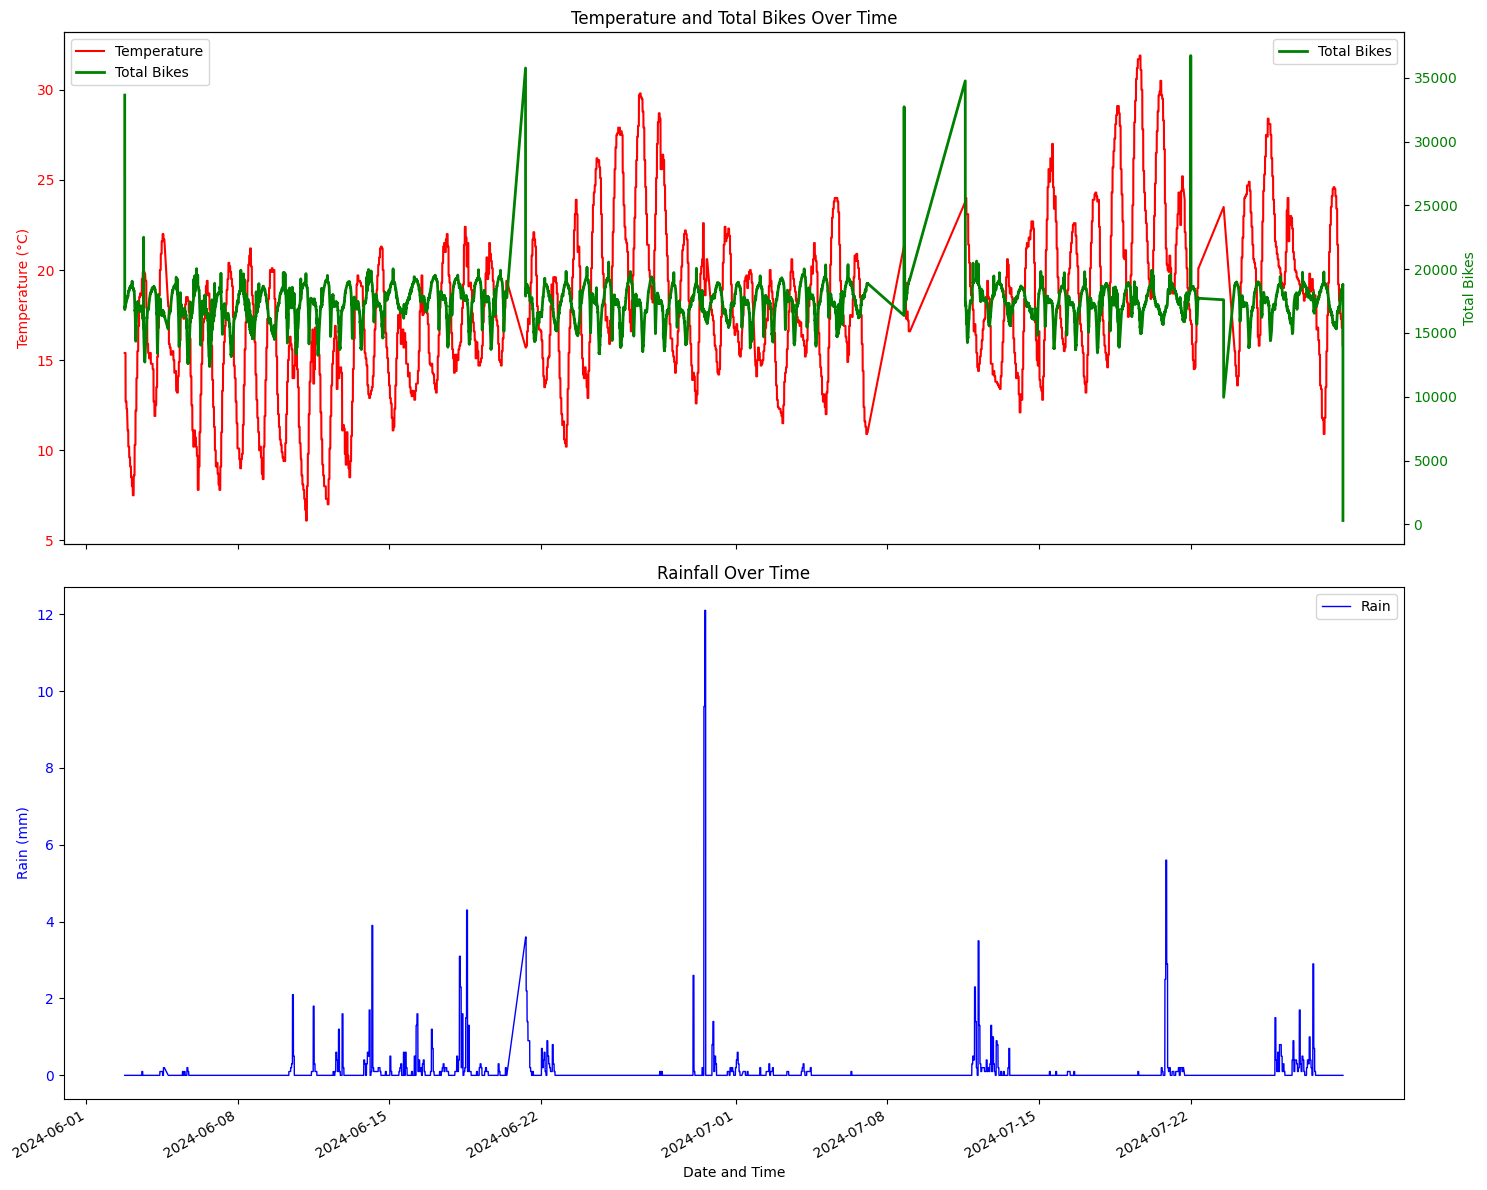

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_seaborn_plots(result_df):
    # Create a figure with two subplots
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

    # Plot temperature on the first subplot
    sns.lineplot(x='record_timestamp', y='temperature_2m', data=result_df, ax=ax1, color='red', label='Temperature')
    ax1.set_ylabel('Temperature (°C)', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Create a twin axis for total bikes
    ax2 = ax1.twinx()

    # Plot total bikes (thick green line)
    sns.lineplot(x='record_timestamp', y='total_bikes', data=result_df, ax=ax2, color='green', linewidth=2, label='Total Bikes')
    ax2.set_ylabel('Total Bikes', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Set title for the first subplot
    ax1.set_title('Temperature and Total Bikes Over Time')

    # Combine legends for the first subplot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Plot rain on the second subplot
    sns.lineplot(x='record_timestamp', y='rain', data=result_df, ax=ax3, color='blue', linewidth=1, label='Rain')
    ax3.set_ylabel('Rain (mm)', color='blue')
    ax3.tick_params(axis='y', labelcolor='blue')
    ax3.set_title('Rainfall Over Time')

    # Set x-label for the bottom subplot
    ax3.set_xlabel('Date and Time')

    # Format x-axis to show dates nicely
    fig.autofmt_xdate()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Assuming you have already run the process_bike_data_with_weather function
# and have the result in result_df
create_seaborn_plots(result_df)

In [28]:
result_df['rain'].max()

np.float64(12.1)

In [15]:


# Example usage
city = "Paris"
datetime = "2024-06-01T12:00:00Z"

# Get latitude and longitude for a city
coordinates = get_lat_long_for_cityname(city)
print(coordinates)

# Get zipcode for latitude and longitude
zipcode_info = get_zipcode_for_lat_long(coordinates["lat"], coordinates["long"])
print(zipcode_info)

# Get current weather for city coordinates
current_weather = get_current_weather_from_city_coordinates(coordinates, datetime)
print(current_weather)

# Get past weather for a city and datetime
past_weather = get_past_weather_for_city(city, datetime)
print(past_weather)

INFO:__main__:Coordinates for Paris: 48.8588897/2.3200410217200766


{'city': 'Paris', 'lat': 48.8588897, 'long': 2.3200410217200766}


INFO:__main__:Zipcode for 48.8588897/2.3200410217200766: 75007
INFO:__main__:The current temperature in Paris is 26.0°C


{'lat': 48.8588897, 'long': 2.3200410217200766, 'zipcode': '75007'}
{'city': 'Paris', 'lat': 48.8588897, 'long': 2.3200410217200766, 'current_weather': {'time': '2024-07-31T19:00', 'interval': 900, 'temperature': 26.0, 'windspeed': 7.7, 'winddirection': 79, 'is_day': 1, 'weathercode': 80}, 'API_response': 200}


INFO:__main__:Coordinates for Paris: 48.8588897/2.3200410217200766
INFO:__main__:API Response: {'latitude': 48.86, 'longitude': 2.3199997, 'generationtime_ms': 0.00095367431640625, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 38.0}
                Could not retrieve past weather for Paris on
                2024-06-01T12:00:00Z from https://api.open-meteo.com.
                Request returned 200.
            


{'city': 'Paris', 'lat': 48.8588897, 'long': 2.3200410217200766, 'past_weather': {'temperature': 'NULL', 'windspeed': 'NULL', 'winddirection': 'NULL', 'weathercode': 'NULL', 'time': '2024-06-01T12:00:00Z'}, 'API_response': 200}
